In [1]:
import re
import pandas as pd

In [2]:
file = open("../../archive/WhatsApp Chat with Nagesh Parmar PLD.txt", 'r', encoding="utf8")

In [3]:
data = file.read()

In [4]:
pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'
messages = re.split(pattern, data)[1:]

In [5]:
dates = re.findall(pattern, data)

In [6]:
df = pd.DataFrame({'date': dates, 'user_message': messages})
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y, %H:%M - ')
df.head()


,date,user_message
0,2022-08-24 15:51:00,Messages and calls are end-to-end encrypted. N...
1,2022-08-24 15:51:00,Your security code with Nagesh Parmar PLD chan...
2,2022-10-01 00:05:00,Nagesh Parmar PLD: jeel kaal college ana padega\n
3,2022-10-01 00:05:00,Nagesh Parmar PLD: aage tumhe kam dene wala hu...
4,2022-10-01 00:40:00,Jeel Gajera: ok time bol\n


In [7]:
users = []
messages = []
for msg in df['user_message']:
    msg_str = re.split('([\w\W]+?):\s', msg)
    if msg_str[1:]:
        users.append(msg_str[1])
        messages.append(msg_str[2])
    else:
        users.append('group_notification')
        messages.append(msg_str[0])

df['user'] = users
df['message'] = messages
df.drop(columns=['user_message'], inplace=True)
df.head()

,date,user,message
0,2022-08-24 15:51:00,group_notification,Messages and calls are end-to-end encrypted. N...
1,2022-08-24 15:51:00,group_notification,Your security code with Nagesh Parmar PLD chan...
2,2022-10-01 00:05:00,Nagesh Parmar PLD,jeel kaal college ana padega\n
3,2022-10-01 00:05:00,Nagesh Parmar PLD,aage tumhe kam dene wala hu hackathon ka tho s...
4,2022-10-01 00:40:00,Jeel Gajera,ok time bol\n


In [8]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df.head()

,date,user,message,year,month,day,hour,minute
0,2022-08-24 15:51:00,group_notification,Messages and calls are end-to-end encrypted. N...,2022,August,24,15,51
1,2022-08-24 15:51:00,group_notification,Your security code with Nagesh Parmar PLD chan...,2022,August,24,15,51
2,2022-10-01 00:05:00,Nagesh Parmar PLD,jeel kaal college ana padega\n,2022,October,1,0,5
3,2022-10-01 00:05:00,Nagesh Parmar PLD,aage tumhe kam dene wala hu hackathon ka tho s...,2022,October,1,0,5
4,2022-10-01 00:40:00,Jeel Gajera,ok time bol\n,2022,October,1,0,40


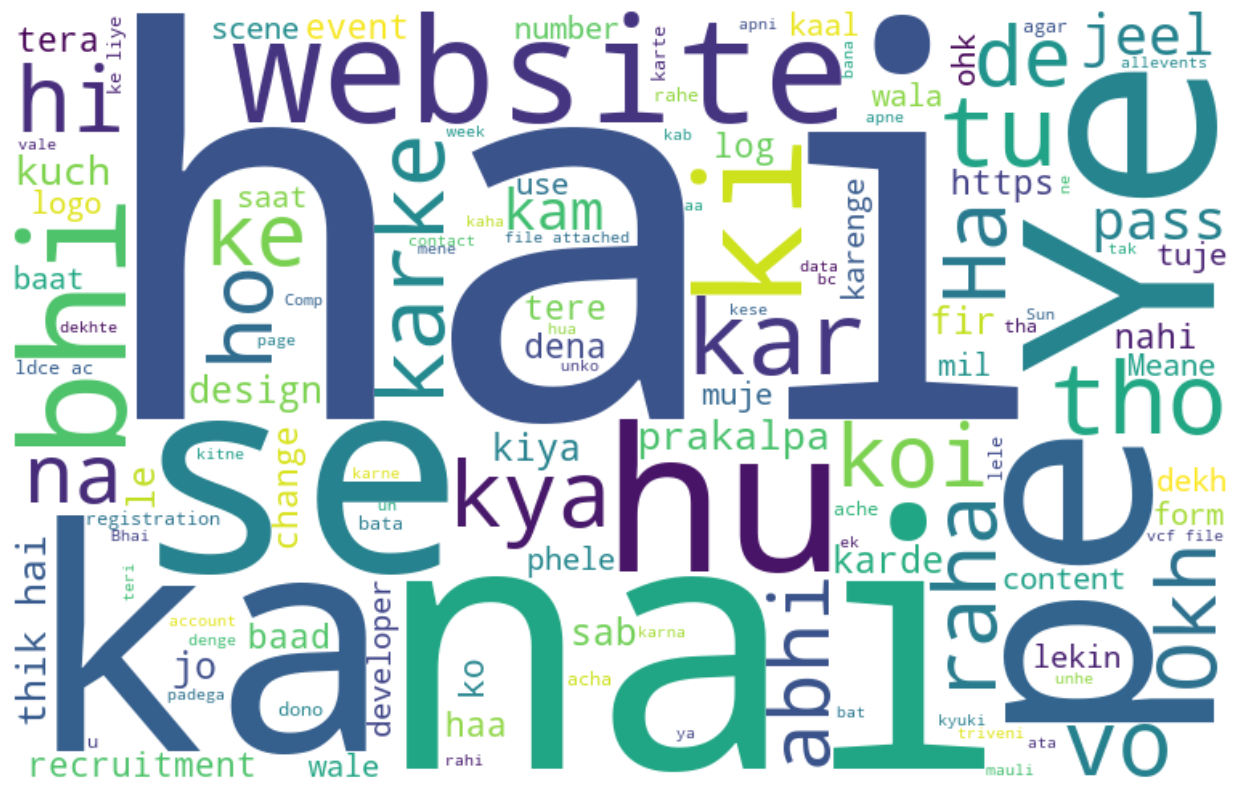

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=760, height=480, min_font_size=10, background_color='white')
# remove media ommited msg
df = df[df.message != '<Media omitted>\n']
#  remove group notification
df = df[df.user != 'group_notification']
wc.generate(' '.join(df['message']))
wc_df = wc.generate(df['message'].str.cat(sep=' '))



plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
from urlextract import URLExtract
extract = URLExtract()

# 1. total msgs
total_msgs = df.shape[0]
# 2. total words
total_words = df.message.str.split().apply(len).sum()
# 3. total media files
total_media = df[df.message == ('<Media omitted>\n')].shape[0]
# 4. total links
links = []
for idx, row in df.iterrows():
    links.extend(extract.find_urls(row['message']))
total_links = len(links)

print(total_msgs, total_words, total_media, total_links)

261 1525 0 5


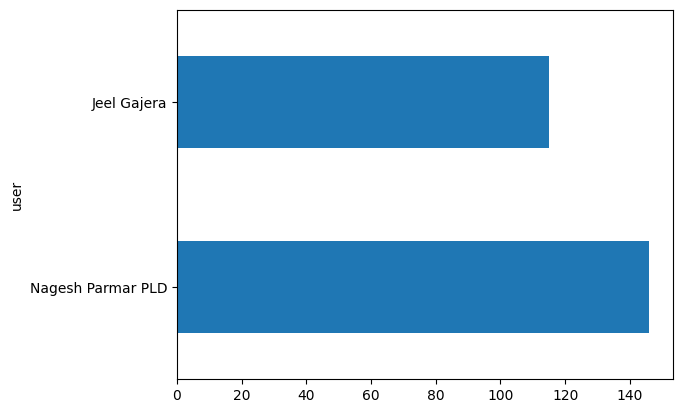

In [11]:
import matplotlib.pyplot as plt

x = df['user'].value_counts().head().plot(kind='barh')


In [12]:
# individual persantage of messages
round((df['user'].value_counts()/df.shape[0])*100, 2).reset_index().rename(columns={'index': 'percentage', 'user': 'name'})

,name,count
0,Nagesh Parmar PLD,55.94
1,Jeel Gajera,44.06


In [13]:
#  get comman words with count
from collections import Counter
f = open('stop_words.txt', 'r', encoding="utf-8")
stop = f.read().split('\n')

words = []
df = df[df.message != '<Media omitted>\n']
#  remove group notification
df = df[df.user != 'group_notification']
# remove stop words
for msg in df['message']:
    for word in msg.split():
        if word.lower() not in stop:
            words.append(word.lower())

top_10 = Counter(words).most_common(10)
# conver to dataframe for ploting purpose
top_10 = pd.DataFrame(top_10).rename(columns={0: 'word', 1: 'count'})
top_10.head()


,word,count
0,website,10
1,ha,9
2,jeel,7
3,okh,6
4,karde,6


In [14]:
import emoji 

emojis = []
for msg in df['message']:
    for char in msg:
        if emoji.is_emoji(char):
            emojis.append(char)

emojis = Counter(emojis)
emojis_df = pd.DataFrame(emojis.items(), columns=['emoji', 'count'])
emojis_df.head()

,emoji,count
0,😂,14
1,🤧,2
2,🥲,1
3,😎,4
4,😅,3


In [15]:
# create timeline  analysis
timeline = df.groupby(['year', 'month']).count()['message'].reset_index()
timeline['period'] = timeline['month'].astype(str) + '-' + timeline['year'].astype(str)
timeline.head()

,year,month,message,period
0,2022,October,13,October-2022
1,2023,April,62,April-2023
2,2023,August,11,August-2023
3,2023,December,62,December-2023
4,2023,February,1,February-2023


<Axes: xlabel='period'>

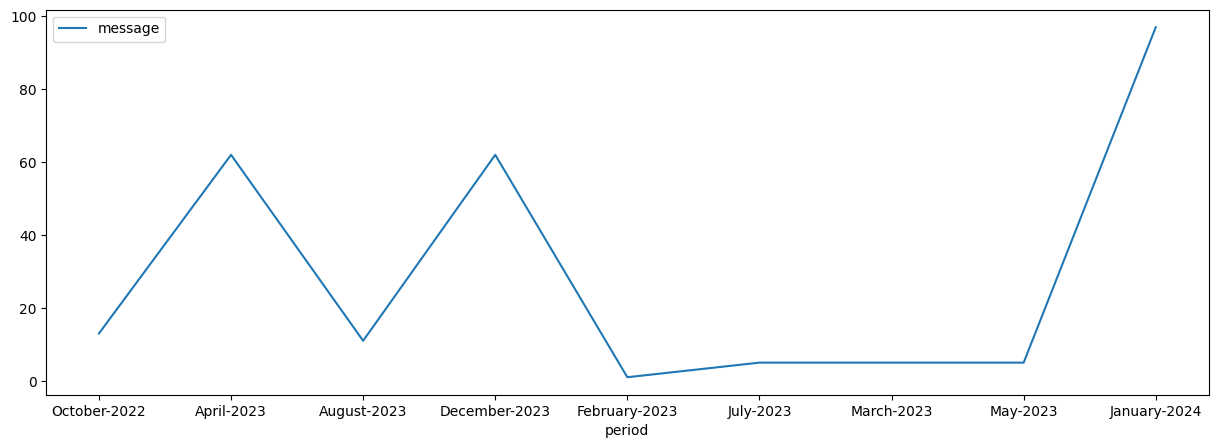

In [16]:
timeline.plot(kind='line', x='period', y='message', figsize=(15, 5))

In [17]:
#  daily timeline
daily_timeline = df.groupby(df['date'].dt.date).count()['message'].reset_index()
daily_timeline.head()

,date,message
0,2022-10-01,10
1,2022-10-07,1
2,2022-10-08,1
3,2022-10-22,1
4,2023-02-23,1


In [18]:
# activity map

# most busy day
df['day_name'] = df['date'].dt.day_name()
df['day_name'].value_counts().head()

day_name
Friday       66
Monday       66
Wednesday    64
Saturday     30
Thursday     20
Name: count, dtype: int64

In [19]:
# most busy month
df['month'].value_counts().head()

month
January     97
April       62
December    62
October     13
August      11
Name: count, dtype: int64

<Axes: xlabel='hour_period', ylabel='day_name'>

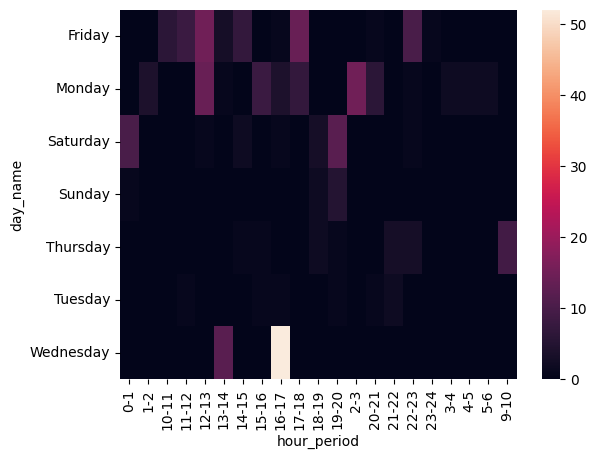

In [20]:
# actiity heatmap
import seaborn as sns

# create hour pireod range
df['hour_period'] = df['hour'].astype(str) + '-' + (df['hour'] + 1).astype(str)
sns.heatmap(df.pivot_table(index='day_name', columns='hour_period', values='message', aggfunc='count').fillna(0))

In [21]:
table = df.pivot_table(index='day_name', columns='hour_period', values='message', aggfunc='count').fillna(0)
print(table)

hour_period   0-1  1-2  10-11  11-12  12-13  13-14  14-15  15-16  16-17  \
day_name                                                                  
Friday        0.0  0.0    6.0    8.0   15.0    3.0    7.0    0.0    1.0   
Monday        0.0  4.0    0.0    0.0   14.0    1.0    0.0    8.0    4.0   
Saturday     10.0  0.0    0.0    0.0    1.0    0.0    2.0    0.0    1.0   
Sunday        1.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Thursday      0.0  0.0    0.0    0.0    0.0    0.0    1.0    1.0    0.0   
Tuesday       0.0  0.0    0.0    1.0    0.0    0.0    0.0    1.0    1.0   
Wednesday     0.0  0.0    0.0    0.0    0.0   12.0    0.0    0.0   52.0   

hour_period  17-18  ...  19-20   2-3  20-21  21-22  22-23  23-24  3-4  4-5  \
day_name            ...                                                      
Friday        14.0  ...    0.0   0.0    1.0    0.0   10.0    1.0  0.0  0.0   
Monday         7.0  ...    0.0  15.0    6.0    0.0    1.0    0.0  2.0  2.0   
Saturday    